# Iteration 7: Regression of prices

## Modules

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
import os
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import parallel_backend

clone = sklearn.clone
sklearn.set_config(transform_output='pandas')

pd.set_option('display.max_colwidth', None)


## Import data

In [13]:
raw_df = pd.read_csv('../data/housing_iteration_6_regression/housing_iteration_6_regression.csv', index_col='Id')
raw_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


Split off labels:

In [14]:
X = raw_df.copy()
y = X.pop('SalePrice')

Split into training vs. test set:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
len(X_train), len(X_test), len(y_train), len(y_test)

(1314, 146, 1314, 146)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 178 to 579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1314 non-null   int64  
 1   MSZoning       1314 non-null   object 
 2   LotFrontage    1078 non-null   float64
 3   LotArea        1314 non-null   int64  
 4   Street         1314 non-null   object 
 5   Alley          88 non-null     object 
 6   LotShape       1314 non-null   object 
 7   LandContour    1314 non-null   object 
 8   Utilities      1314 non-null   object 
 9   LotConfig      1314 non-null   object 
 10  LandSlope      1314 non-null   object 
 11  Neighborhood   1314 non-null   object 
 12  Condition1     1314 non-null   object 
 13  Condition2     1314 non-null   object 
 14  BldgType       1314 non-null   object 
 15  HouseStyle     1314 non-null   object 
 16  OverallQual    1314 non-null   int64  
 17  OverallCond    1314 non-null   int64  
 18  YearBuilt   

Many columns have has some missing rows.

## Handle data types (numerical/nominal/ordinal)

In [17]:
cat_columns = X.select_dtypes(exclude=['number']).columns.append(pd.Index(['MSSubClass']))
len(cat_columns), cat_columns

(44,
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition', 'MSSubClass'],
       dtype='object'))

In [18]:
ord_columns = {
        'ExterQual': [ 'Ex', 'Gd', 'TA', 'Fa', 'Po' ],
        'ExterCond': [ 'Ex', 'Gd', 'TA', 'Fa', 'Po' ],
        'BsmtQual': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'BsmtCond': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'BsmtExposure': [ 'Gd', 'Av', 'NA', 'Mn', 'No' ],
        'BsmtFinType1': [ 'GLQ', 'ALQ', 'NA', 'BLQ', 'Rec', 'LwQ', 'Unf' ],
        'BsmtFinType2': [ 'GLQ', 'ALQ', 'NA', 'BLQ', 'Rec', 'LwQ', 'Unf' ],
        'KitchenQual': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'FireplaceQu': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'LotShape': [ 'Reg', 'IR1', 'IR2', 'IR3' ],
        'Utilities': [ 'AllPub', 'NA', 'NoSewr', 'NoSeWa', 'ELO' ],
        'LandSlope': [ 'Gtl', 'Mod', 'Sev' ],
        'HeatingQC': [ 'Ex', 'Gd', 'TA', 'Fa', 'Po' ],
        'Electrical': [ 'SBrkr', 'FuseA', 'Mix', 'FuseF', 'FuseP', 'NA' ],
        'Functional': [ 'Typ', 'NA', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal' ],
        'GarageFinish': [ 'Fin', 'NA', 'RFn', 'Unf' ],
        'GarageQual': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'GarageCond': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'PoolQC': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa' ],
        'Fence': [ 'GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'NA' ], # review order, experiment?
}
len(ord_columns)

20

In [19]:
num_columns = X.columns.drop(list(cat_columns) + list(ord_columns.keys()))
len(num_columns), num_columns

(35,
 Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'],
       dtype='object'))

In [20]:
nom_columns = cat_columns.drop(list(ord_columns.keys()))
len(nom_columns), nom_columns

(24,
 Index(['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'Foundation', 'Heating', 'CentralAir', 'GarageType', 'PavedDrive',
        'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass'],
       dtype='object'))

### Ordinal encoder

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_pipe = ColumnTransformer(
  transformers=[
    (
      'ordinals',
      make_pipeline(
        SimpleImputer(strategy='constant', fill_value='NA'),
        ColumnTransformer(
          transformers=[
            (
              col,
              OrdinalEncoder(categories = [list(reversed(values))]), #, handle_unknown='use_encoded_value', unknown_value=-1),
              [col]
            )
            for col, values in ord_columns.items()
          ],
          verbose_feature_names_out=False
        )
      ),
      list(ord_columns.keys())
    )
  ],
  remainder='passthrough',
  verbose_feature_names_out=False
)

ord_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinals',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('ExterQual',
                                                                                   OrdinalEncoder(categories=[['Po',
                                                                                                               'Fa',
                                                                                                               'TA',
                                                                                                               'Gd',
                                                                                                               'Ex']]),
                                                                                   ['ExterQual']),
                                                                                  ('ExterCond',
                                                                                   OrdinalEncoder(categories=[['Po',
                                                                                                               'Fa',
                                                                                                               'TA',
                                                                                                               'Gd'...
                                                                                                               'GdWo',
                                                                                                               'GdPrv']]),
                                                                                   ['Fence'])],
                                                                    verbose_feature_names_out=False))]),
                                 ['ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'KitchenQual', 'FireplaceQu',
                                  'LotShape', 'Utilities', 'LandSlope',
                                  'HeatingQC', 'Electrical', 'Functional',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'PoolQC', 'Fence'])],
                  verbose_feature_names_out=False)

### Nominal encoder

In [22]:
nom_pipe = make_pipeline(
  SimpleImputer(strategy='constant', fill_value='unknown'),
  OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'),
)
nom_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='unknown', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                               sparse_output=False))])

### Numerical preprocessor

In [23]:
num_pipe = make_pipeline(
  SimpleImputer(strategy='mean')
)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

### Full preprocessor

In [24]:
from sklearn.pipeline import Pipeline


preprocessor = Pipeline(
  steps=[
    ('ordinals', ord_pipe),
    (
      'categoricals',
      ColumnTransformer(
        transformers=[
          ('nominals', nom_pipe, lambda X: X.columns.intersection(X.select_dtypes(exclude=['number']).columns.union(nom_columns)).tolist()),
          ('numericals', num_pipe, lambda X: X.columns.intersection(num_columns).tolist())
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
      )
    )
  ]
)
preprocessor

Pipeline(steps=[('ordinals',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinals',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(transformers=[('ExterQual',
                                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                                'Fa',
                                                                                                                                'TA',
                                                                                                                                'Gd',
                                                                                                                                'Ex']]),
                                                                                                    ['ExterQual']),
                                                                                                   ('ExterCond',
                                                                                                    OrdinalEncoder(cate...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False))]),
                                                  <function <lambda> at 0x7f404cf17ce0>),
                                                 ('numericals',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <function <lambda> at 0x7f404cf17f60>)],
                                   verbose_feature_names_out=False))])

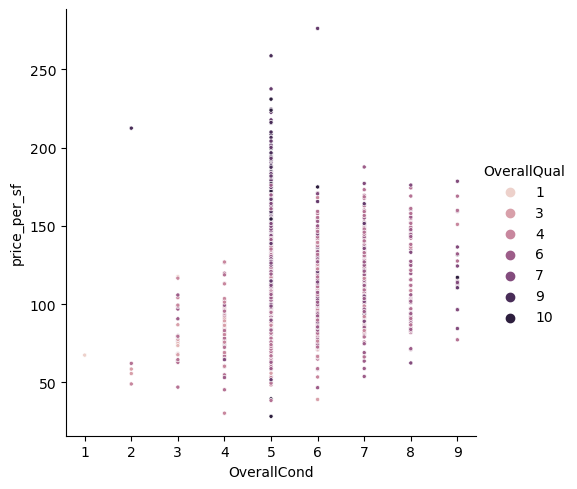

In [26]:

sns.relplot(data=raw_df.assign(price_per_sf = lambda x: x.SalePrice / x.GrLivArea), marker='.', x='OverallCond', y='price_per_sf', hue='OverallQual')

## Scaling

In [28]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
# scaler = RobustScaler(quantile_range=(10, 90))
scaler = ColumnTransformer(
  transformers=[
    ('numeric_scaler', RobustScaler(quantile_range=(10,90)), lambda X: X.columns.intersection(list(num_columns) + list(ord_columns.keys())).tolist())
  ],
  remainder='passthrough',
  verbose_feature_names_out=False)

class SilentColumnTransformer(ColumnTransformer):
  def __repr__(self):
    return '[...]'

scaler.__class__ = SilentColumnTransformer
# scaler = QuantileTransformer()

In [29]:
make_pipeline(preprocessor, scaler).fit_transform(X_train).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 178 to 579
Columns: 235 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(235)
memory usage: 2.4 MB


## Challenge data

In [30]:
#challenge_df = pd.read_csv('../data/housing_iteration_6_competition/test.csv', index_col='Id')
#challenge_df

## Result scores

In [31]:
result_scores = pd.DataFrame(columns=['r2', 'rmse', 'rmsle', 'mape', 'params'])

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

def ratings(y_true, y_pred):
  if isinstance(y_pred, np.ndarray):
    y_pred = pd.Series(y_pred)

  return pd.Series({
    'r2': r2_score(y_true, y_pred),
    'rmse': mean_squared_error(y_true, y_pred, squared=False),
    'rmsle': mean_squared_log_error(y_true, y_pred.clip(lower=1e-10), squared=False),
    'mape': mean_absolute_percentage_error(y_true, y_pred)
  })


## Baseline: Average price per sq.f.

In [33]:
from sklearn.base import BaseEstimator, RegressorMixin

class BaselineModel(RegressorMixin, BaseEstimator):
    def __init__(self):# , *, param=1):
        #self.param = param
        pass
    def fit(self, X, y):
        self.avg_price_sf = (y / X.GrLivArea).mean()
        self.is_fitted_ = True
        return self
    def predict(self, X):
        return X.GrLivArea * self.avg_price_sf


## Rescaling prices to sq.f.

In [34]:
class PerSfModel(RegressorMixin, BaseEstimator):
    def __init__(self, nested_regressor, column = 'GrLivArea'):# , *, param=1):
        self.nested_regressor = nested_regressor
        self.column = column
    def fit(self, X, y):
        self.nested_regressor.fit(X, y / X[self.column])
        self.is_fitted_ = True
        return self
    def predict(self, X):
        return X[self.column] * self.nested_regressor.predict(X)


## PCA

In [35]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pca = make_pipeline(
  StandardScaler(),
  PCA(n_components=0.95),
  #MinMaxScaler((-1,1), clip=True)
)

pca_pipe = ColumnTransformer(
  transformers=[
    ('keep', 'passthrough', ['GrLivArea']),
    ('pca', pca, lambda X: X.columns)
  ],
  verbose_feature_names_out=False
)


## Approach: Grid search on decision tree model

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('scaler', None),
  ('pca', None),
  ('model', BaselineModel())
])

In [37]:
result_scores = result_scores.iloc[0:0]

In [ ]:
import math
from sklearn.feature_selection import RFECV
from sklearn.linear_model import HuberRegressor, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR, NuSVR


param_grids = dict(
  # baseline = {},
  #  tree = {
  #    'model': [ DecisionTreeRegressor() ],
  #    #'columntransformer__numericals__simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
  #    'model__min_impurity_decrease': [0, 0.005], #[0.004, 0.005, 0.006], #[0, 0.005, 0.01, 0.05, 0.1],
  #    'model__max_depth': range(2, 30, 5),
  #    'model__min_samples_leaf': np.logspace(0, 2, 5).astype(int), #range(3, 10, 2),
  #    'model__min_samples_split': np.logspace(0, 2, 5).astype(int) + 1, # range(4, 40, 5),
  #    #'decisiontreeclassifier__criterion':['gini', 'entropy']
  #  },
  # tree_sf = {
  #   'model': [ PerSfModel(DecisionTreeRegressor()) ],
  #   #'columntransformer__numericals__simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
  #   'model__nested_regressor__min_impurity_decrease': [0, 0.005], #[0.004, 0.005, 0.006], #[0, 0.005, 0.01, 0.05, 0.1],
  #   'model__nested_regressor__max_depth': range(2, 30, 5),
  #   'model__nested_regressor__min_samples_leaf': np.logspace(0, 2, 5).astype(int), #range(3, 10, 2),
  #   'model__nested_regressor__min_samples_split': np.logspace(0, 2, 5).astype(int) + 1, # range(4, 40, 5),
  #   #'decisiontreeclassifier__criterion':['gini', 'entropy']
  # },
  # sgd = [
  #   {
  #     'model': [ make_pipeline(MinMaxScaler((-1, 1)), SGDRegressor()) ],
  #     'model__sgdregressor__loss': ['squared_error'],
  #     'model__sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],
  #     'model__sgdregressor__alpha': np.logspace(-4, -1, 5),
  #   },
  #   {
  #     #'scaler': [ scaler ],
  #     'model': [ SGDRegressor() ],
  #     'model__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
  #     'model__penalty': ['l2', 'l1', 'elasticnet'],
  #     'model__alpha': np.logspace(-4, 1, 5),
  #     'model__epsilon': np.logspace(-4, 0, 5),
  #   }
  # ],
  # sgd_sf = [
  #   {
  #     #'scaler': [ scaler ],
  #     'model': [ PerSfModel(make_pipeline(MinMaxScaler((-1, 1)), SGDRegressor())) ],
  #     'model__nested_regressor__sgdregressor__loss': ['squared_error'],
  #     'model__nested_regressor__sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],
  #     'model__nested_regressor__sgdregressor__alpha': np.logspace(-4, -1, 5),
  #   },
  #   {
  #     #'scaler': [ scaler ],
  #     'model': [ PerSfModel(SGDRegressor()) ],
  #     'model__nested_regressor__loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
  #     'model__nested_regressor__penalty': ['l2', 'l1', 'elasticnet'],
  #     'model__nested_regressor__alpha': np.logspace(-4, 1, 5),
  #     'model__nested_regressor__epsilon': np.logspace(-4, 0, 5),
  #   }
  # ],
  # forest = {
  #   'model': [ RandomForestRegressor() ],
  #   'model__n_estimators': [90, 100, 120],
  #   'model__max_depth': np.linspace(20, 30, 5).astype(int),
  #   'model__min_samples_split': [2, 6, 21],
  #   'model__min_samples_leaf': [1, 5, 10],
  # },
  # forest_sf = {
  #   'model': [ PerSfModel(RandomForestRegressor()) ],
  #   'model__nested_regressor__n_estimators': [90, 100, 120],
  #   'model__nested_regressor__max_depth': np.linspace(20, 30, 5).astype(int),
  #   'model__nested_regressor__min_samples_split': [2, 6, 21],
  #   'model__nested_regressor__min_samples_leaf': [1, 5, 10],
  # },
  # gradient_boosting = {
  #   'model': [ GradientBoostingRegressor() ],
  #   'model__n_estimators': [90],
  #   'model__max_depth': [4],
  #   'model__min_samples_split': [2],
  #   'model__min_samples_leaf': [1],
  #   'model__subsample': [1],
  # },
  # gradient_boosting_sf_nom = {
  #   'preprocessor__ordinals': [None],
  #   'model': [ PerSfModel(GradientBoostingRegressor()) ],
  #   'model__nested_regressor__n_estimators': [300],
  #   'model__nested_regressor__max_depth': [5],
  #   'model__nested_regressor__min_samples_split': [21],
  #   # 'model__nested_regressor__min_samples_leaf': [1, 2, 5],
  #   # 'model__nested_regressor__subsample': [1, 0.8, 0.5],
  # },
  gradient_boosting_sf = {
    'model': [ PerSfModel(GradientBoostingRegressor()) ],
    'model__nested_regressor__n_estimators': [250, 300, 350],
    'model__nested_regressor__learning_rate': [0.05, 0.1, 0.2],
    'model__nested_regressor__max_depth': [4, 5, 6],
    'model__nested_regressor__min_samples_split': [17, 21, 23],
    # 'model__nested_regressor__min_samples_leaf': [1, 2, 5],
    # 'model__nested_regressor__subsample': [1, 0.8, 0.5],
  },
#    'model__nested_regressor__learning_rate': 0.1,
#  'model__nested_regressor__max_depth': 5,
#  'model__nested_regressor__min_samples_split': 21,
#  'model__nested_regressor__n_estimators': 300}

  # gradient_boosting_sf_opt = {
    # 'model': [ PerSfModel(GradientBoostingRegressor()) ],
    # 'model__nested_regressor__max_depth': 5,
    # 'model__nested_regressor__min_samples_leaf': 1,
    # 'model__nested_regressor__min_samples_split': 21,
    # 'model__nested_regressor__n_estimators': 300
  # }
  # svm_sf = [
  #   {
  #     'model': [ PerSfModel(NuSVR()) ],
  #     'model__nested_regressor__nu': np.logspace(-1, 0, 5),
  #     'model__nested_regressor__C': np.logspace(-1, 0, 3),
  #     'model__nested_regressor__kernel': ['poly'],
  #     'model__nested_regressor__degree': [2, 3],
  #   },
  #   {
  #     'model': [ PerSfModel(NuSVR()) ],
  #     'model__nested_regressor__nu': np.logspace(-1, 0, 5),
  #     'model__nested_regressor__C': np.logspace(-1, 0, 3),
  #     'model__nested_regressor__kernel': ['rbf', 'sigmoid'],
  #   },
  # ]
  # linear_sf = {
  #   'model': [ PerSfModel(LinearRegression()) ]
  # },
  #poly_sf = {
  #  'model': [ PerSfModel(make_pipeline(MinMaxScaler(), PolynomialFeatures(), LinearRegression())) ]
  #},
  #poly = {
  #  'model': [ make_pipeline(MinMaxScaler(), PolynomialFeatures(), LinearRegression()) ]
  #},
  # linear = {
  #   'model': [ LinearRegression() ]
  # },
  # lasso = {
  #   'model': [ Lasso()],
  #   'model__alpha': np.logspace(.9, 1.1, 10, base=88),
  # },
  # lasso_sf = {
  #   'model': [ PerSfModel(Lasso())],
  #   'model__nested_regressor__alpha': np.logspace(-2, 0, 10),
  # },
  # knn_sf = {
  #   'model': [ PerSfModel(make_pipeline(MinMaxScaler(), KNeighborsRegressor())) ],
  #   'model__nested_regressor__kneighborsregressor__n_neighbors': range(2, 20, 2),
  #   'model__nested_regressor__kneighborsregressor__weights': ['uniform', 'distance'],
  #   'model__nested_regressor__kneighborsregressor__p': [1, 2],
  # },
  # knn = {
  #   'model': [ make_pipeline(MinMaxScaler(), KNeighborsRegressor()) ],
  #   'model__kneighborsregressor__n_neighbors': range(2, 20, 2),
  #   'model__kneighborsregressor__weights': ['uniform', 'distance'],
  #   'model__kneighborsregressor__p': [1, 2],
  # },
  # ridge = {
  #   'model': [ Ridge() ],
  #   'model__alpha': np.logspace(0, 2, 11),
  #   'model__tol': [10**-6], #np.logspace(-6, -3, 11)
  # },
  # ridge_sf_nom = {
  #   'preprocessor__ordinals': [ None ],
  #   'model': [ PerSfModel(Ridge()) ],
  #   'model__nested_regressor__alpha': [10**-0.4], #np.logspace(-0.4, 1, 11),
  #   'model__nested_regressor__tol': [10**-6], #np.logspace(-6, -3, 11),
  # },
  # ridge_sf = {
  #   'model': [ PerSfModel(Ridge()) ],
  #   'model__nested_regressor__alpha': [10**-0.4], #np.logspace(-0.4, 1, 11),
  #   'model__nested_regressor__tol': [10**-6], #np.logspace(-6, -3, 11),
  # },
  # pca_ridge_sf = {
  #   'pca': [ pca_pipe ],
  #   'model': [ PerSfModel(Ridge()) ],
  #   'model__nested_regressor__alpha': np.logspace(0, 2, 11),
  # },
  # ridge_poly_sf = {
  #   'model': [ PerSfModel(make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())) ],
  #   'model__nested_regressor__ridge__alpha': [0.1], #np.logspace(-1, 1, 5),
  #   'model__nested_regressor__ridge__tol': [1e-5], # np.logspace(-5, -3, 3),
  # },
  # huber_sf = {
  #   'model': [ PerSfModel(make_pipeline(StandardScaler(), HuberRegressor(max_iter=1000))) ],
  #   'model__nested_regressor__huberregressor__epsilon': [1, 1.15, 1.35, 2],
  #   'model__nested_regressor__huberregressor__alpha': np.logspace(-5, 0, 6)
  #}
)
# os.environ['PYTHONPATH'] = sklearn.__path__[0]
os.environ['PYTHONWARNINGS'] = 'ignore:Maximum number of iteration reached before convergence:UserWarning'

for name, grid in param_grids.items():
  search = GridSearchCV(
    pipe,
    grid,
    cv=5,
    refit=True,
    scoring='r2',
    verbose=10,
    n_jobs=-1
  )

  search.fit(X=X_train, y=y_train)

  result_scores.loc[name] = {
    **ratings(y_test, search.predict(X_test)),
    'params': search.best_params_
  }

result_scores

In [39]:
result_scores

,r2,rmse,rmsle,mape,params
gradient_boosting_sf_nom,0.853222,38280.468722,0.160477,0.104376,"{'model': PerSfModel(nested_regressor=GradientBoostingRegressor(max_depth=5, min_samples_split=21, n_estimators=300)), 'model__nested_regressor__max_depth': 5, 'model__nested_regressor__min_samples_split': 21, 'model__nested_regressor__n_estimators': 300, 'preprocessor__ordinals': None}"
gradient_boosting_sf,0.869030,36160.319810,0.152124,0.095965,"{'model': PerSfModel(nested_regressor=GradientBoostingRegressor(max_depth=5, min_samples_split=21, n_estimators=300)), 'model__nested_regressor__learning_rate': 0.1, 'model__nested_regressor__max_depth': 5, 'model__nested_regressor__min_samples_split': 21, 'model__nested_regressor__n_estimators': 300}"


In [40]:
result_scores.loc['gradient_boosting_sf', 'params']

{'model': PerSfModel(nested_regressor=GradientBoostingRegressor(max_depth=5,
                                                       min_samples_split=21,
                                                       n_estimators=300)),
 'model__nested_regressor__learning_rate': 0.1,
 'model__nested_regressor__max_depth': 5,
 'model__nested_regressor__min_samples_split': 21,
 'model__nested_regressor__n_estimators': 300}

In [ ]:
search.best_score_

In [ ]:
search.best_params_

In [ ]:
tree_columns = search.best_estimator_[-1].feature_names_in_

In [ ]:
plt.figure(figsize=(30, 15))
plot_tree(search.best_estimator_[-1], feature_names=tree_columns, proportion=False and True, rounded=True, filled=True, fontsize=10);